In [63]:
%load_ext autoreload 

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from easydict import EasyDict as edict
import yaml
import pandas as pd
import os

from scipy.signal import convolve2d, convolve
from scipy.signal.windows import blackman, gaussian
import copy
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from collections import defaultdict
from joblib import Parallel, delayed
from umap import UMAP

from IPython.core.debugger import set_trace
from IPython.display import clear_output

import torch
from torch import nn
from torch import optim

from network_utils import get_capacity, to_numpy, plot_weights_hist, L2_loss, train
from input_utils import create_I

plt.rcParams['font.size'] = 20
device = torch.device('cuda:0')
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
def init_weights(self):
    for p in self.parameters():
        nn.init.xavier_normal_(p)

class f_theta(nn.Module):
    
    def __init__(self, input_dim, hidden_dim=100):
        
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.theta1 = nn.Parameter(torch.zeros(self.hidden_dim, self.input_dim, requires_grad=True))
        self.bias1 = nn.Parameter(torch.zeros(self.hidden_dim, self.input_dim, requires_grad=True))
        self.theta2 = nn.Parameter(torch.zeros(1, self.hidden_dim, requires_grad=True))
        
        init_weights(self)
        
    def forward(self, x):
        
        '''
        x - [d, T]
        '''
        
        x = torch.sigmoid(x.unsqueeze(0) * self.theta1.unsqueeze(-1) + self.bias1.unsqueeze(-1))
        x = torch.einsum('mh,hdt->mdt', self.theta2, x).squeeze(0)
        
        return x
    
    
# class f_theta(nn.Module):
    
#     def __init__(self, input_dim, hidden_dim=100):
        
#         super().__init__()
        
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
        
#         self.linear1 = nn.Linear(1,hidden_dim)
#         self.linear2 = nn.Linear(hidden_dim,1, bias=False)
        
# #         init_weights(self)
        
#     def forward(self, x):
        
#         '''
#         x - [d, T]
#         '''
        
#         x = torch.sigmoid(self.linear1(x.T))
#         x = self.linear2(x).T
        
#         return x

In [155]:
f_θ = f_theta(1, hidden_dim=10)
batch_size = 1000
epochs = 100000
tol = 1e-2
losses = []

opt = optim.Adam(f_θ.parameters(), lr=1e-3, weight_decay=1)

for epoch in tqdm(range(epochs)):
    
    X = torch.randn(1, batch_size)
    Y = np.tanh(X)
    
    Y_pred = f_θ(X)
    loss = torch.abs(Y-Y_pred).mean()
    loss.backward()
    opt.step()
    
    losses.append(loss.item())
    
    if loss < tol:
        break

 14%|████████████████▌                                                                                                      | 13923/100000 [00:06<00:37, 2265.33it/s]


In [156]:
X.shape

torch.Size([1, 1000])

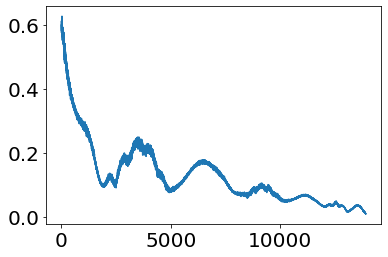

In [157]:
plt.plot(losses)

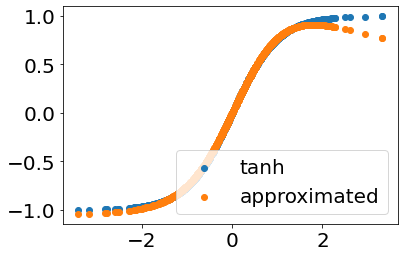

In [158]:
X = torch.randn(1, batch_size)
Y = np.tanh(X)
Y_pred = f_θ(X)

plt.scatter(X, Y, label='tanh')
plt.scatter(X, Y_pred.detach(), label='approximated')
plt.legend()

plt.show()